In [4]:
import numpy as np

class smol_brain(object):
    def __init__(self, layer_sizes, learning_rate=0.01, max_epochs=1000, batch_size=20):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.num_layers = len(layer_sizes) - 1
        # weights and biases initialization (He initialization)
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(4. / (layer_sizes[i] + layer_sizes[i+1])) for i in range(self.num_layers)]
        self.biases = [np.zeros((1, layer_sizes[i+1])) for i in range(self.num_layers)]
        # cache for storing activations and inputs
        self.cache = {}

    def forward_propagation(self, x):
        self.cache['a0'] = x
        for i in range(self.num_layers):
            z = self.cache[f'a{i}'] @ self.weights[i] + self.biases[i]
            self.cache[f'z{i+1}'] = z
            self.cache[f'a{i+1}'] = self.relu(z) if i < self.num_layers - 1 else z
        return self.cache[f'a{self.num_layers}']

    def compute_loss(self, y, y_hat):
        loss = np.mean((y_hat - y)**2)
        return loss

    def backpropagate(self, y):
        deltas = [None] * self.num_layers
        grads_w = [None] * self.num_layers
        grads_b = [None] * self.num_layers
        
        # Output layer error
        deltas[-1] = self.cache[f'a{self.num_layers}'] - y
        grads_w[-1] = self.cache[f'a{self.num_layers-1}'].T @ deltas[-1]
        grads_b[-1] = np.sum(deltas[-1], axis=0, keepdims=True)
        
        for i in range(self.num_layers - 2, -1, -1):
            deltas[i] = (deltas[i+1] @ self.weights[i+1].T) * self.relu(self.cache[f'z{i+1}'], derivative=True)
            grads_w[i] = self.cache[f'a{i}'].T @ deltas[i]
            grads_b[i] = np.sum(deltas[i], axis=0, keepdims=True)
        
        return grads_w, grads_b

    def stochastic_gradient_descent_step(self, grads_w, grads_b):
        for i in range(self.num_layers):
            self.weights[i] -= self.learning_rate * grads_w[i] / self.batch_size
            self.biases[i] -= self.learning_rate * grads_b[i] / self.batch_size

    def fit(self, X, y, X_val=None, y_val=None, get_validation_loss=False):
        training_loss = []
        if get_validation_loss:
            validation_loss = []
        n_samples = X.shape[0]
        n_batches = n_samples // self.batch_size

        for epoch in range(self.max_epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for batch in range(n_batches):
                start = batch * self.batch_size
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                y_hat = self.forward_propagation(X_batch)
                loss = self.compute_loss(y_batch, y_hat)
                grads_w, grads_b = self.backpropagate(y_batch)
                self.stochastic_gradient_descent_step(grads_w, grads_b)
                training_loss.append(loss)
                
                if get_validation_loss:
                    X_val_batch = X_val[start:end]
                    y_val_batch = y_val[start:end]
                    y_val_hat = self.forward_propagation(X_val_batch)
                    val_loss = self.compute_loss(y_val_batch, y_val_hat)
                    validation_loss.append(val_loss)

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')

        if get_validation_loss:
            return training_loss, validation_loss
        return training_loss

    def predict(self, X):
        return self.forward_propagation(X)

    def relu(self, x, derivative=False):
        if derivative:
            return np.where(x > 0, 1, 0)
        return np.maximum(0, x)


In [2]:
def makeSincData(n,noise=0.03):
  # Define the grid of points
  x = np.random.uniform(-6,6,n)

  # Calculate the sinc function
  y = np.sinc(np.sqrt((x)**2))+np.random.normal(0, noise, n) +2

  return (x,y)

# Number of samples
n = 500
noise = 0.001;

# Validation and test data
x_train,y_train = makeSincData(n, noise)
x_val,y_val = makeSincData(n, noise)
x_test,y_test = makeSincData(n, noise)

Epoch 0, Loss: 0.7090380866573558
Epoch 100, Loss: 0.0026244942645570236
Epoch 200, Loss: 0.0017479453653641674
Epoch 300, Loss: 0.0018912469579087231
Epoch 400, Loss: 0.0014733232547989544
Epoch 500, Loss: 0.0009642913356115385
Epoch 600, Loss: 0.0019189416695354303
Epoch 700, Loss: 0.0006404805003854177
Epoch 800, Loss: 0.0006629159560463012
Epoch 900, Loss: 0.0003664494439325224


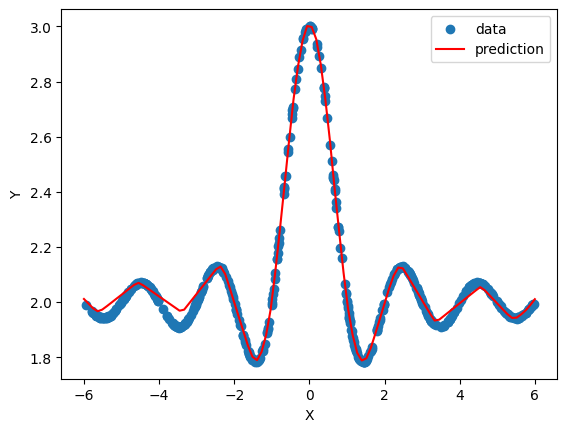

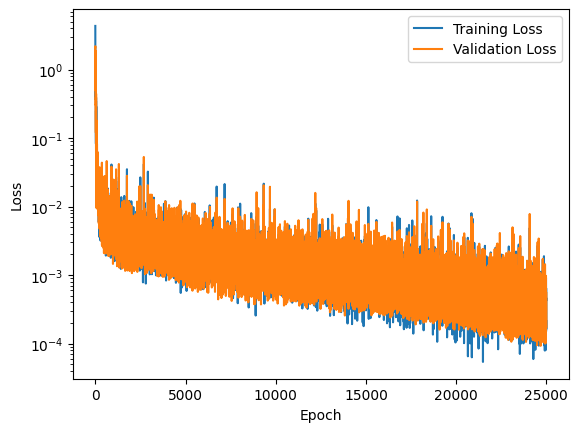

In [21]:
import matplotlib.pyplot as plt
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_val = x_val.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

layer_sizes = [1, 150, 150, 150, 150, 150, 150, 150, 150, 150, 1]
smol = smol_brain(layer_sizes=layer_sizes, learning_rate=0.01, max_epochs=1000, batch_size=20)
training_loss, validation_loss = smol.fit(x_train, y_train, x_val, y_val, get_validation_loss=True)

x_range = np.linspace(-6,6,100)
y_hat = smol.predict(x_range.reshape(-1,1))

plt.scatter(x_train,y_train)
plt.plot(x_range, y_hat, 'r')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['data', 'prediction'])

plt.show()

plt.plot(training_loss)
plt.plot(validation_loss)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()
